# General metrics

In [ ]:
# lee el csv con todas las predicciones y obtiene métricas
import pandas as pd
import numpy as np

data = pd.read_csv("predictions_full.csv")
#data['netmhcpan4.1_pred_SB'] = data.apply(lambda row: (  1 if row['netmhcpan4.1_ligand'] == "SB" else 0  ), axis=1)
#data.to_csv("predictions2.csv", index=False)
print(data.head(3))
print()

# para el caso de ACME, no utlizamos todo xq no teneia algunos HLA
hlas_non_acme = ['HLA-C*01:02', 'HLA-C*02:02', 'HLA-C*03:03',
 'HLA-C*03:04', 'HLA-C*04:01', 'HLA-C*05:01' ,'HLA-C*06:02', 'HLA-C*07:01',
 'HLA-C*07:02', 'HLA-C*07:04' ,'HLA-C*08:02', 'HLA-C*12:03', 'HLA-C*14:02',
 'HLA-C*15:02', 'HLA-C*16:01','HLA-C*17:01',  "HLA-A*02:50", "HLA-A*24:06", "HLA-A*24:13", "HLA-A*32:15", "HLA-B*45:06", "HLA-B*83:01"]
data_acme = data.loc[~(data['HLA'].isin(hlas_non_acme))]
print(data_acme.shape)
print(data_acme['HLA'].unique())

In [21]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef
)
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(metrics, file_name):
    metrics_tape = metrics['tape']
    metrics_esm2t6 = metrics['esm2']
    metrics_anthem = metrics['anthem']
    metrics_netmhcpan = metrics['netmhcpan4.1']
    metrics_acme = metrics['acme']
    # data from https://allisonhorst.github.io/palmerpenguins/
    metrics = ("AUC", "Accuracy", "Presicion", "Recall", "F1-score", "MCC")
    results = {
        'Tape': (metrics_tape["auc"], metrics_tape["accuracy"], metrics_tape["precision"], metrics_tape["recall"], metrics_tape["f1score"], metrics_tape["mcc"]),
        'ESM2-t6': (metrics_esm2t6["auc"], metrics_esm2t6["accuracy"], metrics_esm2t6["precision"], metrics_esm2t6["recall"], metrics_esm2t6["f1score"], metrics_esm2t6["mcc"]),
        'Anthem': (metrics_anthem["auc"], metrics_anthem["accuracy"], metrics_anthem["precision"], metrics_anthem["recall"], metrics_anthem["f1score"], metrics_anthem["mcc"]),
        'NetMHCpan4.1': (metrics_netmhcpan["auc"], metrics_netmhcpan["accuracy"], metrics_netmhcpan["precision"], metrics_netmhcpan["recall"], metrics_netmhcpan["f1score"], metrics_netmhcpan["mcc"]),
        'Acme': (metrics_acme["auc"], metrics_acme["accuracy"], metrics_acme["precision"], metrics_acme["recall"], metrics_acme["f1score"], metrics_acme["mcc"]),
    }

    colors = {'Tape':'#104E8B', 'ESM2-t6':'#3F6D9B', 'Anthem':'#6E8DAB', 'NetMHCpan4.1':'#9DACBB', 'Acme':'#CCCCCC'}

    x = np.arange(len(metrics))  # the label locations
    width = 0.18  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in results.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[attribute])
        #ax.bar_label(rects, padding=3) # agrega el valor arriba de cada barra
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Metric value')
    #ax.set_title('guin attributes by species')
    ax.set_xticks(x + width, metrics)
    ax.legend(loc='upper left', ncols=4)
    ax.set_ylim(0, 1.2)

    plt.savefig("../plots/" + file_name, dpi=300, bbox_inches='tight')
    plt.clf()

def get_metrics(y_test, y_test_predictions, y_probs):
    accuracy = accuracy_score(y_test, y_test_predictions)
    precision = precision_score(y_test, y_test_predictions)
    recall = recall_score(y_test, y_test_predictions)
    f1score = f1_score(y_test, y_test_predictions)
    #auc = roc_auc_score(y_test, y_test_predictions)
    mcc = matthews_corrcoef(y_test, y_test_predictions)
    conf_matrix = confusion_matrix(y_test, y_test_predictions)
    auc = roc_auc_score(y_test, y_probs)

    return {    "accuracy":accuracy, 
                "precision":precision, 
                "recall":recall, 
                "f1score":f1score, 
                "auc":auc,
                "mcc":mcc, 
                "conf_matrix":conf_matrix}


metrics_anthem = get_metrics(data["Label"], data["anthem_pred"], data["anthem_prob"])
metrics_netmhcpan = get_metrics(data["Label"], data["netmhcpan4.1_pred_SB"], data["netmhcpan4.1_prob"])
metrics_tape = get_metrics(data["Label"], data["tape_pred"], data["tape_prob"])
metrics_esm2t6 = get_metrics(data["Label"], data["esm2t6_pred"], data["esm2t6_prob"])
metrics_acme = get_metrics(data_acme["Label"], data_acme["acme_pred"], data_acme["acme_prob"])
#print(metrics_anthem)
#print(metrics_netmhcpan)
#print(metrics_tape)
#print(metrics_esm2t6)
#print(metrics_acme)

plot_metrics({'tape':metrics_tape, 'anthem':metrics_anthem, 'acme':metrics_acme,
              'netmhcpan4.1':metrics_netmhcpan, 'esm2':metrics_esm2t6}, "metrics_comparison.png")


<Figure size 640x480 with 0 Axes>

In [18]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

def plot_ROC(data_pd, file_name, full=False):
    y_test = data_pd["Label"]
    
    if full: # cuando proceso todo, considero q acme no tiene todas las muestras
        acme = data_acme["acme_prob"]
        y_test_acme = data_acme["Label"]
        fpr5, tpr5, _ = metrics.roc_curve(y_test_acme,  acme)
        auc5 = metrics.roc_auc_score(y_test_acme, acme)
    else: # cuando el por hla, no es neceario 
        acme = data_pd["acme_prob"]
        fpr5, tpr5, _ = metrics.roc_curve(y_test,  acme)
        auc5 = metrics.roc_auc_score(y_test, acme)

    
    anthem = data_pd["anthem_prob"]
    esm2t6 = data_pd["esm2t6_prob"]
    tape = data_pd["tape_prob"]
    netmhcpan = data_pd["netmhcpan4.1_prob"].astype(float)

    fpr1, tpr1, _ = metrics.roc_curve(y_test,  anthem)
    fpr2, tpr2, _ = metrics.roc_curve(y_test,  tape)
    fpr3, tpr3, _ = metrics.roc_curve(y_test,  esm2t6)
    fpr4, tpr4, _ = metrics.roc_curve(y_test,  netmhcpan)

    auc1 = metrics.roc_auc_score(y_test, anthem)
    auc2 = metrics.roc_auc_score(y_test, tape)
    auc3 = metrics.roc_auc_score(y_test, esm2t6)
    auc4 = metrics.roc_auc_score(y_test, netmhcpan)

    plt.plot(fpr1,tpr1,label="Anthem, AUC="+str(round(auc1,3)))
    plt.plot(fpr2,tpr2,label="TAPE, AUC="+str(round(auc2,3)))
    plt.plot(fpr3,tpr3,label="ESM2-t6, AUC="+str(round(auc3,3)))
    plt.plot(fpr4,tpr4,label="NetMHCpan4.1, AUC="+str(round(auc4,3)))
    plt.plot(fpr5,tpr5,label="Acme, AUC="+str(round(auc5,3)))

    plt.legend(loc=4)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    #plt.show()
    plt.savefig("../plots/" + file_name, dpi=300, bbox_inches='tight')
    plt.clf()

plot_ROC(data, "ROC_comparison.png", True)

<Figure size 640x480 with 0 Axes>

# Metrics Plots by HLA and peptide length

Aquí, obtendremos las métricas pero por peptide lenght y HLA. Hacemos esto porque otras investigaciones lo separarn así.

In [22]:
# lee el csv con todas las predicciones y obtiene métricas
import pandas as pd
import numpy as np

data = pd.read_csv("predictions_full.csv")
#print(data.head(3))

# group by peptide length (k-mer)
data_grouped = []  # cada elemento es un dataframe. 
# Ex: data_list[0] contiene los datos de peptidos de longitud 8
# Ex: data_list[1] contiene los datos de peptidos de longitud 9

for i in range(8,15):
    data_by_kmer = data[data['Length'] == i] 
    data_by_kmer_acme = data_acme[data_acme['Length'] == i] 
    data_grouped.append(data_by_kmer)
    #peptides.to_csv(str(i) + "-mer.csv", index=False)
    
    metrics_anthem = get_metrics(data_by_kmer["Label"], data_by_kmer["anthem_pred"], data_by_kmer["anthem_prob"])
    metrics_netmhcpan = get_metrics(data_by_kmer["Label"], data_by_kmer["netmhcpan4.1_pred_SB"], data_by_kmer["netmhcpan4.1_prob"])
    metrics_tape = get_metrics(data_by_kmer["Label"], data_by_kmer["tape_pred"], data_by_kmer["tape_prob"])
    metrics_esm2t6 = get_metrics(data_by_kmer["Label"], data_by_kmer["esm2t6_pred"], data_by_kmer["esm2t6_prob"])
    metrics_acme = get_metrics(data_by_kmer_acme["Label"], data_by_kmer_acme["acme_pred"], data_by_kmer_acme["acme_prob"])

    plot_metrics({'tape':metrics_tape, 'anthem':metrics_anthem, 'acme':metrics_acme,
              'netmhcpan4.1':metrics_netmhcpan, 'esm2':metrics_esm2t6}, "metrics_comparison_" + str(i) + "mer.png")
    

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

#data_8_mer = data_grouped[0]
#data_by_hla = data_8_mer[data_8_mer['HLA'] == "HLA-A*11:01"] # dividimos 
#data_by_hla = data_8_mer[data_8_mer['HLA'] == "HLA-B*27:05"] # dividimos 
#plot_ROC(data_by_hla)

def plot_ROC_by_HLA(hla):
    for i, data_k_mer in enumerate(data_grouped):
        data_by_hla = data_k_mer[data_k_mer['HLA'] == hla] # dividimos 
        print(str(i+8)+"-mer", data_by_hla.shape, "shape--------")
        file_name = "ROC_" + hla + "_" + str(i + 8) + "-mer.png"
        #print(file_name)
        if data_by_hla.shape[0] > 0:
            plot_ROC(data_by_hla, file_name)

plot_ROC_by_HLA("HLA-B*27:05")
plot_ROC_by_HLA("HLA-A*11:01")

8-mer (313, 19) shape--------
9-mer (4251, 19) shape--------
10-mer (1767, 19) shape--------
11-mer (1169, 19) shape--------
12-mer (1497, 19) shape--------
13-mer (1013, 19) shape--------
14-mer (761, 19) shape--------
8-mer (35, 19) shape--------
9-mer (2707, 19) shape--------
10-mer (1177, 19) shape--------
11-mer (467, 19) shape--------
12-mer (125, 19) shape--------
13-mer (37, 19) shape--------
14-mer (0, 19) shape--------


<Figure size 640x480 with 0 Axes>

# Boxplot distributions

In [3]:
import pandas as pd

data = pd.read_csv("predictions_mixmhcpred.csv")
print(data.head(3))

   id          HLA   peptide  Label  Length  \
0   1  HLA-A*01:01  LFGRDLSY      1       8   
1   2  HLA-A*01:01  TDKKTHLY      1       8   
2   3  HLA-A*01:01  RSDTPLIY      1       8   

                                  mhc  mixmhcpred_score  mixmhcpred_rank  
0  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY         -1.768960         2.741370  
1  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY         -1.871118         3.238930  
2  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY          0.103419         0.079745  


In [6]:
# see rank values
print(max(data["mixmhcpred_rank"]))
print(min(data["mixmhcpred_rank"]))
print(sum(data["mixmhcpred_rank"])/len(data["mixmhcpred_rank"]))

98.5726
0.001
17.08436647698179


In [15]:
# getting best threshold
from sklearn.metrics import f1_score, precision_recall_curve
import numpy as np

# Assuming you have your predicted probabilities and true labels
predicted_probs = data["mixmhcpred_rank"]
true_labels = data["Label"]

# Create a range of threshold values to evaluate
# se establecio hasta 30, xq el promedio era 17 de las prob. Luego, al evaluar hasta 100, los resultados bajan
thresholds = np.linspace(0, 30, 100)  # Adjust the number of thresholds as needed


# Initialize variables to store best threshold and best F1-score
best_threshold = None
best_f1_score = 0

# Iterate through thresholds and calculate F1-score for each
for threshold in thresholds:
    binary_predictions = (predicted_probs < threshold).astype(int) # los rank mas pequeños son mejores en mixmhcpred
    f1 = f1_score(true_labels, binary_predictions)
    
    # Update best threshold if F1-score improves
    if f1 > best_f1_score:
        best_threshold = threshold
        best_f1_score = f1

print("Best Threshold:", best_threshold)
print("Best F1-Score:", best_f1_score)

Best Threshold: 3.3333333333333335
Best F1-Score: 0.8821491290521619


[0.0, 0.7703182210158757, 0.8217270755989984, 0.8455609030793911, 0.8595949017905036, 0.8680419369437321, 0.8732058604420164, 0.8769987171381746, 0.8794038269833937, 0.8810902321322064, 0.8816039596858075, 0.8821491290521619, 0.8817766781538099, 0.8814261877579695, 0.8809185881477, 0.879742772711238, 0.8786274070113098, 0.8775093627605135, 0.8765747370935544, 0.8753564477436292, 0.8738812317293665, 0.872234398560514, 0.8708320314243628, 0.8694033582628601, 0.8678422628104754, 0.8660415197461212, 0.8645055765346448, 0.8627320193543097, 0.8609164038799841, 0.8593472776104826, 0.8578177533215857, 0.8562365359758725, 0.8548014018064627, 0.8532004107479034, 0.8512928163843765, 0.8492945635211313, 0.8475515893377625, 0.8458796481829112, 0.8440879994113752, 0.842207244714668, 0.8403279766595859, 0.8386455634293801, 0.8368971615573315, 0.8351213156792696, 0.8333084183449919, 0.8316742127956994, 0.8300339757813661, 0.8282910874897792, 0.826535135768625, 0.8250262955980915, 0.8235258346340177, 0

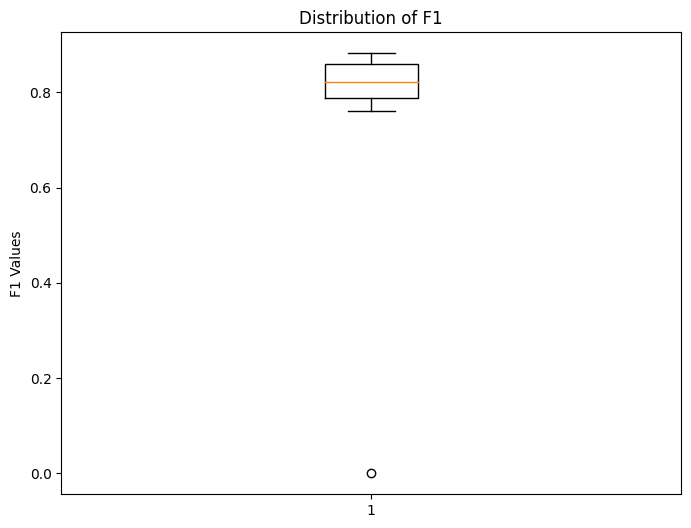

0.06135054502312988


In [17]:
# getting AUC values
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

# Assuming you have your predicted probabilities and true labels
predicted_probs = data["mixmhcpred_rank"]
true_labels = data["Label"]

thresholds = np.linspace(0, 30, 100)  # Define the thresholds you want to evaluate

f1_values = []  # To store AUC values for each threshold

for threshold in thresholds:
    binary_predictions = (predicted_probs < threshold).astype(int)
    f1 = f1_score(true_labels, binary_predictions)
    #auc = roc_auc_score(true_labels, binary_predictions)
    f1_values.append(f1)

# Print or analyze the AUC values for different thresholds
print(f1_values)

import matplotlib.pyplot as plt

# Assuming you have a list or array of AUC values named 'auc_values'
plt.figure(figsize=(8, 6))
plt.boxplot(f1_values)
plt.title('Distribution of F1')
plt.ylabel('F1 Values')
plt.show()
plt.clf()

auc = roc_auc_score(true_labels, predicted_probs)
print(auc)

  Tools        F1
0   Mix  0.000000
1   Mix  0.770318
2   Mix  0.821727
3   Mix  0.845561
4   Mix  0.859595


<Axes: xlabel='Tools', ylabel='F1'>

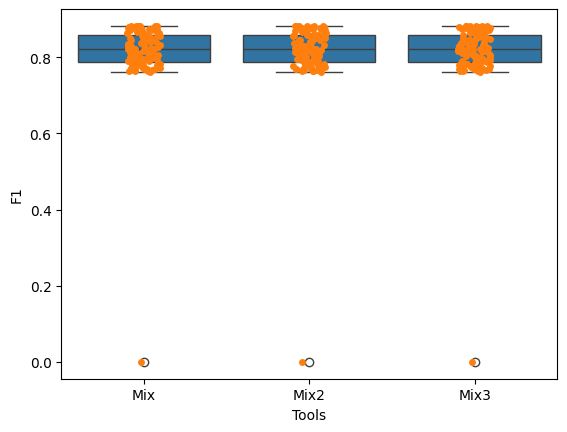

In [24]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.DataFrame()
df["Mix"] = f1_values
df["Mix2"] = f1_values
df["Mix3"] = f1_values
df = df.melt(var_name='Tools',value_name='F1')
print(df.head())

sns.boxplot(x = "Tools",
            y = "F1",
            data = df)
sns.stripplot(x = "Tools",
              y = "F1",
              data = df)